In [1]:
%%capture
!pip install contextily

In [1]:
import requests
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def query_to_gdf_vis(data):
    gdf = gpd.GeoDataFrame.from_features(data["features"])
    gdf.crs = "EPSG:4326"
    gdf = gdf.to_crs(epsg=3857)
    ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
    ctx.add_basemap(
        ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=gdf.crs.to_string()
    )
    plt.show()
    return gdf

In [3]:
example_aoi_name = (
    "https://api.cerulean.skytruth.org/collections/public.aoi/items"  # This is the endpoint for all AOI data
    "?filter=LOWER(name) LIKE '%medit%'"  # filter by name (helps to search for what aois we can look at)
)

data = requests.get(example_aoi_name).json()
print("Number of results:", len(data["features"]))
print(data["features"][1]["properties"])

aoi_id = data["features"][0]["properties"]["id"]
aoi_id2 = data["features"][1]["properties"]["id"]

Number of results: 5
{'id': 363, 'name': 'Mediterranean Sea - Western Basin', 'type': 2}


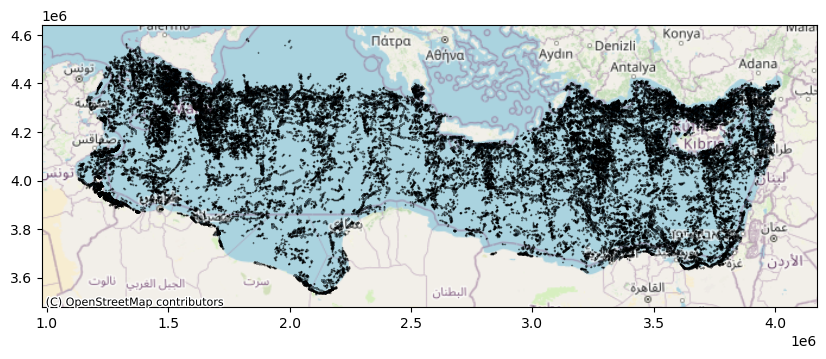

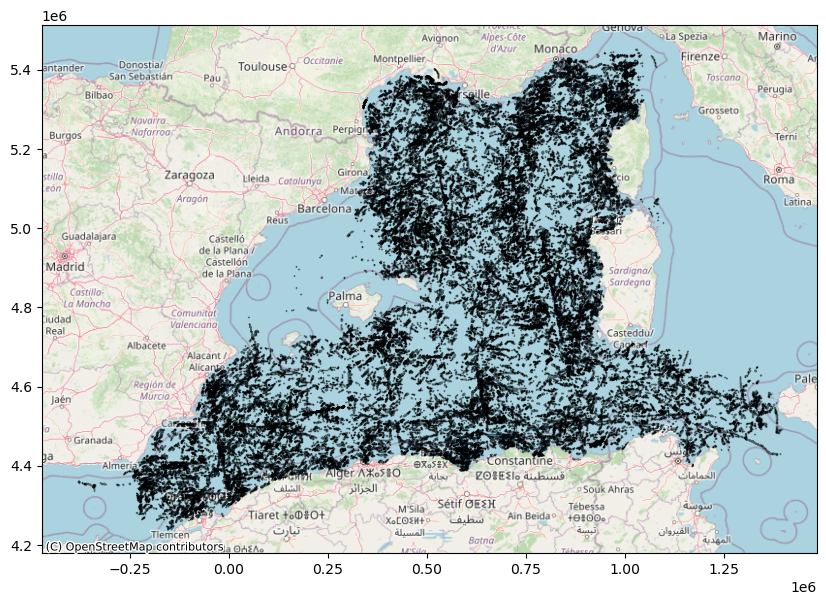

In [4]:
def get_slicks_by_aoi(aoi_id):
    '''takes an aoi_id input and queries it with our specified characteristics'''
    url = (
        "https://api.cerulean.skytruth.org/collections/public.get_slicks_by_aoi/items"
        "?limit=9999" # limiting to 100 for now while testing (default if not specific is 10, max is 9999)
        "&sortby=slick_timestamp" # self explanatory
        "&datetime=2020-01-01T00:00:00Z/2025-01-01T00:00:00Z"  # Limit results to a specific date range (jan 01 2020 to jan 01 2025)
        "&filter=machine_confidence GTE 0.95"  # Sort by machine confidence in descending order, only return spills with detection confidence greater than or equal to .95
        "&filter=(NOT source_type_1_ids IS NULL OR NOT source_type_2_ids IS NULL)"
        f"&aoi_id={aoi_id}" # by specific area of interest id, for us it's mediterranean west basin and med east basin : f is used bc API queries read in weird sometimes, this helps it read it the way we want
    )
    data = requests.get(url).json()
    # print("Response for AOI:", aoi_id)
    # print(data)  # add these two lines to debug if needed
    return query_to_gdf_vis(data)

# query both AOIs and combine the gdfs
gdf1 = get_slicks_by_aoi(aoi_id)
gdf2 = get_slicks_by_aoi(aoi_id2)


In [9]:
gdf_combined = gpd.GeoDataFrame(pd.concat([gdf1, gdf2], ignore_index=True))

In [5]:
gdf_combined.head()
# gdf_combined.shape

,geometry,active,aoi_type_1_ids,aoi_type_2_ids,aoi_type_3_ids,area,cls,cls_long_name,cls_short_name,create_time,...,length,linearity,machine_confidence,orchestrator_run,perimeter,polsby_popper,s1_scene_id,slick_timestamp,source_type_1_ids,source_type_2_ids
0,"MULTIPOLYGON (((1689561.034 4289870.9, 1689713...",True,[168],[326],None,1.250759e+06,5,Vessel,VESSEL,2024-11-25T19:46:26.347343,...,10648.920757,3243.977091,0.737940,177207,23714.391474,0.027949,S1B_IW_GRDH_1SDV_20200813T050444_20200813T0505...,2020-08-13T05:04:44,"[8841, 89535, 169054, 47349, 452409]",None
1,"MULTIPOLYGON (((1512988.395 4292510.359, 15132...",True,[168],[326],None,5.000123e+05,5,Vessel,VESSEL,2024-11-25T19:46:26.347343,...,8983.757208,3289.103808,0.719593,177207,11315.309150,0.049075,S1B_IW_GRDH_1SDV_20200813T050444_20200813T0505...,2020-08-13T05:04:44,"[45379, 452438]",None
2,"MULTIPOLYGON (((1571468.865 4247482.663, 15716...",True,"[168, 224]",[326],"[15349, 15723]",3.191843e+07,3,Natural,NATURAL,2024-11-25T19:46:26.347343,...,131484.261930,525297.021986,0.713053,177207,623699.193413,0.001031,S1B_IW_GRDH_1SDV_20200813T050444_20200813T0505...,2020-08-13T05:04:44,"[452375, 327541, 452379, 136246, 307971, 45243...",None
3,"MULTIPOLYGON (((1673735.521 4186810.753, 16738...",True,[168],[326],"[14089, 14093, 14894, 14896]",1.366692e+08,3,Natural,NATURAL,2024-11-25T19:46:26.347343,...,84260.326311,9069.612466,0.979694,177207,547578.856634,0.005728,S1B_IW_GRDH_1SDV_20200813T050444_20200813T0505...,2020-08-13T05:04:44,"[452843, 89535, 86152, 731, 452844]",None
4,"MULTIPOLYGON (((1590648.434 4254058.755, 15908...",True,[168],[326],"[14091, 14092, 14892, 15349, 15721, 15723]",9.907100e+06,3,Natural,NATURAL,2024-11-25T19:46:26.347343,...,37291.494067,37737.514643,0.712722,177207,182948.284639,0.003720,S1B_IW_GRDH_1SDV_20200813T050444_20200813T0505...,2020-08-13T05:04:44,"[310611, 78451, 452375, 452379, 327541, 141457...",None


In [ ]:
#gdf_combined.explore() # display combined map (with both med west and east)

In [10]:
gdf_projected = gdf_combined.to_crs(epsg=3035)
gdf_centroids = gdf_projected.copy()
gdf_centroids['geometry'] = gdf_projected['geometry'].centroid

In [11]:
gdf_centroids = gdf_centroids.to_crs(gdf_combined.crs)

# Step 3: Extract centroid coordinates into new columns
gdf_centroids['longitude'] = gdf_centroids.geometry.x
gdf_centroids['latitude'] = gdf_centroids.geometry.y

# Step 4: Drop the geometry column if you only want CSV with coordinates
teamoilspillcentroids_csv = gdf_centroids.drop(columns='geometry')

# Step 5: Save to CSV
teamoilspillcentroids_csv.to_csv('teamoilspillcentroids.csv', index=False)

In [7]:
gdf_combined['geometry'] = gdf_combined['geometry'].apply(lambda geom: geom.wkt)

# Save to CSV
gdf_combined.to_csv("teamoilspill.csv", index=False)

/tmp/ipykernel_636/554839876.py:1: UserWarning: Geometry column does not contain geometry.
  gdf_combined['geometry'] = gdf_combined['geometry'].apply(lambda geom: geom.wkt)
